# Module 2 Final Project

* Student name: JAMES SAVORY
* Student pace: PART TIME
* Scheduled project review date/time: JUNE 11, 2019; 3PM EST 
* Instructor name: BRANDON LEWIS
* Blog post URL:https://jsavory-94.github.io/module_2_project_rough

# A. Appendix

## I. Executive Summary

This goal of this project is to generate insights that can add business value to the Northwind Traders company. We will do this by asking four key business questions, and corresponding technical/statistical questions:

- Q1 Business: Can the Company Increase Demand for its Products? <br>
- Q1 Technical: [Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?](#1) <br><br>

- Q2 Business: Can the Company Reduce its Payroll? <br>
- Q2 Technical: [Does the Age of an Employee Have a Statistically Significant Effect on Their Sales Performance?](#2) <br><br>

- Q3 Business: Can the Company Improve its Operational Efficiency? <br>
- Q3 Technical: [Is there a statistically significant difference between the average order processing time in North America vs. Western Europe?](#3) <br><br>

- Q4 Business: Can the Company Increase its Revenue Stream? <br>
- Q4 Technical: [Which Product Categories Generate Significantly More Revenue Than Average? Which Ones Significantly Less?](#4)

## II. Import Libraries 

In [1]:
import sqlite3
import pandas as pd
import math
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib as plt
from scipy.stats import norm, kstest
from scipy.stats import ks_2samp

## III. Connect to the Database

In [2]:
connection = sqlite3.connect('Northwind_small.sqlite')
cursor = connection.cursor()

## IV. Define Global Functions

These functions will be responsible for making tasks that need to be repeated throughout the notebook efficient and readable.

In [3]:
def sql_select_to_df(SQL_COMMAND, cursor=cursor):
    """returns output of SQL command in dataframe format"""
    results = cursor.execute(SQL_COMMAND).fetchall()
    df = pd.DataFrame(results)
    df.columns = [i[0] for i in cursor.description]
    return df

def get_cohen_d(pop1, pop2,pop1_name,pop2_name):
    '''returns cohen\'s d statistic between two populations'''
    
    #Numerator
    mean_difference = pop1.mean() - pop2.mean()

    # Demominator
    n1, n2 = len(pop1), len(pop2)
    var1 = pop1.var()
    var2 = pop2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    pooled_std = np.sqrt(pooled_var)
    
    # Calculate Cohen's d
    d = mean_difference / np.sqrt(pooled_var)
    d = abs(d)
    
    print(f'Populations compared: {pop1_name}, {pop2_name}')
    print(f'Cohen\'s d: {d}')
    
    d_as_int = int(d *100000) #to make range function in if statements usable
    
    if d_as_int in range(0,34999): 
        print('effect size: small')
    elif d_as_int in range(35000,64999):
        print('effect size: medium')
    else:
        print('effect size: large') #source for effect size figures: Cohen, J. (1992). A power primer. Psychological Bulletin, 112, 155-159
    
    print('--------------------')
    

def visualize(experimental,control):
    plt.pyplot.figure(figsize=[20,12])
    
    ax = plt.pyplot.subplot(331)
    ax
    sns.distplot(experimental,fit=norm).set_title('distribution of experimental population')
    
    ax1 = plt.pyplot.subplot(332)
    ax1.set_title('distribution of control population')
    sns.distplot(control, fit=norm)

<a id="1"></a>
# 1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount? 

## 1.1 Do discounts have a statistically significant effect on the number of products customers order?

### 1.1.1 Source Data From Database

The two pieces of information we are looking to analyze in this first part of the question are both found in the OrderDetail table of the database, under the column names "Quantity" and "Discount" respectively.

In [4]:
orderDetail_df = sql_select_to_df("""select * from OrderDetail;""")
#orderDetail_df = orderDetail_df.iloc[:,-2:]
orderDetail_df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
5,10250/41,10250,41,7.70,10,0.00
6,10250/51,10250,51,42.40,35,0.15
7,10250/65,10250,65,16.80,15,0.15
8,10251/22,10251,22,16.80,6,0.05
9,10251/57,10251,57,15.60,15,0.05


### 1.1.2 Extract Relevant Data to Test

Distinct sample groups must be extracted from the dataframe to pass to our chosen hypothesis test. For this first part of our question, where we are asking whether discounts have a significant effect on number of products ordered in general, the groups to be tested are: <br><br> 1. discounted orders <br>  2. non-discounted orders.

In [5]:
non_discounted_df = orderDetail_df.loc[orderDetail_df['Discount'] == 0]
discounted_df = orderDetail_df.loc[orderDetail_df['Discount'] != 0]

discounted_orderQuantities = discounted_df['Quantity'].values
non_discounted_orderQuantities = non_discounted_df['Quantity'].values

#discounted_orderQuantities = list(discounted_orderQuantities)

### Test for Normality

/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


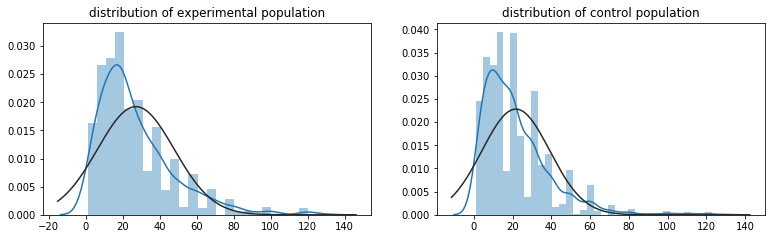

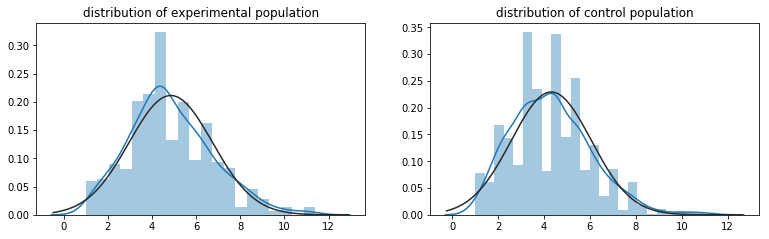

In [6]:
visualize(discounted_orderQuantities, non_discounted_orderQuantities)
visualize(np.sqrt(discounted_orderQuantities), np.sqrt(non_discounted_orderQuantities))

In [7]:
def normality_check(population):
    population_mean = population.mean()
    population_std = population.std()
    population_length = len(population)
    
    normal = np.random.normal(population_mean, population_std, population_length)
    return stats.ks_2samp(population, normal)
    
print(normality_check(discounted_orderQuantities))
print(normality_check(np.sqrt(non_discounted_orderQuantities)))

Ks_2sampResult(statistic=0.16467780429594275, pvalue=2.042602406462905e-10)
Ks_2sampResult(statistic=0.06302201974183741, pvalue=0.010168375400199598)


After taking the square root of the data, we now have a suitably normal distribution we can pass to our parametric test below.

#### Non-Discounted

The above represents the quantity of products ordered from each individual order detail that did not have a discount applied. There were 1317 discounted purchase orders in total. 

This will be the dataset to be used in our hypothesis test as the control group.

### 1.1.3 Test Hypothesis

#### Generate Test Question

We want to test whether there is simply **any** difference between the means in the quantity column of our **two** sample groups, so a **two-sample** t test will be chosen. The null and alternate hypotheses for this test are the following:


- $H_0$: There is no statistically significant difference between the number of products ordered in the discounted and non-discounted populations

- $H_\alpha$: There is a statistically significant difference between the number of products ordered in the discounted and non-discounted populations

#### Run Test

In [8]:
#Function
def run_twoSample_tTest(population1, population2, alpha):
    """Generates test conclusion given populations and alpha level"""
    def get_t_statistic(pop1, pop2):
        """Calculates and returns t-statistic figure of two populations"""
        def variance(sample):
            sample_mean = np.mean(sample)
            return sum([(i - sample_mean)**2 for i in sample])
    
        def sample_variance(sample1, sample2):
            n_1, n_2 = len(sample1), len(sample2)
            var_1, var_2 = variance(sample1), variance(sample2)
            return (var_1 + var_2)/((n_1 + n_2)-2)
        
        pop1_mean, pop2_mean = np.mean(pop1), np.mean(pop2)
        samp_var = sample_variance(pop1, pop2)
        n_pop1, n_pop2 = len(pop1), len(pop2)
        t_numerator = pop1_mean - pop2_mean
        t_denominator = np.sqrt(samp_var * ((1/n_pop1)+(1/n_pop2)))
        return t_numerator / t_denominator
    
    t = get_t_statistic(population1, population2)
    p = stats.t.sf(abs(t), len(population1)+len(population2)-1) * 2
    
    if p < alpha:
        return 'reject null hypothesis'
    else:
        return 'fail to reject null hypothesis'

In [9]:
run_twoSample_tTest(np.sqrt(discounted_orderQuantities), np.sqrt(non_discounted_orderQuantities), 0.05)

'reject null hypothesis'

#### Technical Conclusion
From the results of our t-test performed where we rejected the null hypothesis at an alpha level of 0.05, we can state with 95% confidence that there in fact **is a statistically significant difference** between number of discounted products ordered and non-discounted on the whole.

#### Business Conclusion

Increasing demand for products through discounts is a viable strategy to explore further.

## 1.2 At what level of discount is there a statistically significant effect on the number of products customers order?

For this second part of our question we will need to repeat the above process, but instead of testing the mean of the **entire** discounted population against our non-discounted control population, we will need to use multiple experimental populations - i.e. separate experimental groups at  **each level of discount**.

### 1.2.1 Extract Relevant Data to Test

In order to create these separate experimmental groups, we first need to determine the unique discount rates that exist in the dataset.

In [10]:
discount_rates = discounted_df['Discount'].unique()
discount_rates = list(discount_rates)
discount_rates.sort()

print(discount_rates)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.15, 0.2, 0.25]


With this information, the separate groups can be created.

In [11]:
def get_discountLevel_data(rate):
    df = orderDetail_df.loc[orderDetail_df['Discount'] == rate]
    vals = df['Quantity'].values
    
    return vals

def get_discountLevel_sampleSize(rate):
    val = get_discountLevel_data(rate)
    return len(val)

def get_discountLevel_data_all(disc_rates):
    master_list = []
    for d in disc_rates:
        quantity_vals = [{'discount rate': d, 'data':get_discountLevel_data(d), 'sample size': get_discountLevel_sampleSize(d)}]
        master_list.append(quantity_vals)
        
    return master_list

In [12]:
discounted_data = get_discountLevel_data_all(discount_rates)
discounted_data

[[{'discount rate': 0.01, 'data': array([2]), 'sample size': 1}],
 [{'discount rate': 0.02, 'data': array([1, 3]), 'sample size': 2}],
 [{'discount rate': 0.03, 'data': array([1, 2, 2]), 'sample size': 3}],
 [{'discount rate': 0.04, 'data': array([1]), 'sample size': 1}],
 [{'discount rate': 0.05,
   'data': array([  6,  15,  40,  25,  12,  60,  20,  24,  15,  60,  33,  12,   6,
           10,   8,  20,  12,  70,  20,  12,  40,   4,  20,  77,  10,  10,
           10,  20,  56,  70,  80,  42,  30,  40,  30,  18,  60,  20, 100,
           16,  20,  80,   2,  20,  35,  30,  60,  20,  20,  12,   8,  16,
           10,  50,  24,  15,  24,  30,  20,  20,  10,  12,  18,  16,   6,
           25,  15,  60,  15,   9,  30,  50,  60,  25,   5,  25,  30,  20,
           70,  15,  15,  15,  15,  12,  30,  20,  25,  60,  25,  70,  55,
           70,  20,  24,  40,  30,  30,  20,   8,  12,  65,   8,   3,  32,
           25,  50,  20,  10,  10,  15,   3,  10,  40,  30,  28,  30,  15,
           16,  12

### 1.2.2 Run Hypothesis Tests

With our multiple experimental groups now created, we can test the following hypothesis test on each:
- $H_0$: There is **no** statistically significant difference between the number of products ordered at x% discounted and those with no discount

- $H_\alpha$: There **is** a statistically significant difference between the number of products ordered at x% discounted and those with no discount

In [13]:
def get_t_test_outcomes_twoSample(experimental, control):
    i=0
    while i < len(experimental):
        print(str(experimental[i][0]['discount rate']*100) + '% discount rate test outcome: ' + str(run_twoSample_tTest(experimental[i][0]['data'], control, 0.05)))
        print((str(experimental[i][0]['discount rate']*100) + '% discount rate sample size: ') + str(experimental[i][0]['sample size']))
        print('--------------------------------')
        i+=1

In [14]:
get_t_test_outcomes_twoSample(discounted_data,non_discounted_orderQuantities)

1.0% discount rate test outcome: fail to reject null hypothesis
1.0% discount rate sample size: 1
--------------------------------
2.0% discount rate test outcome: fail to reject null hypothesis
2.0% discount rate sample size: 2
--------------------------------
3.0% discount rate test outcome: reject null hypothesis
3.0% discount rate sample size: 3
--------------------------------
4.0% discount rate test outcome: fail to reject null hypothesis
4.0% discount rate sample size: 1
--------------------------------
5.0% discount rate test outcome: reject null hypothesis
5.0% discount rate sample size: 185
--------------------------------
6.0% discount rate test outcome: fail to reject null hypothesis
6.0% discount rate sample size: 1
--------------------------------
10.0% discount rate test outcome: reject null hypothesis
10.0% discount rate sample size: 173
--------------------------------
15.0% discount rate test outcome: reject null hypothesis
15.0% discount rate sample size: 157
-------

In [15]:
def get_t_test_effect_sizes_twoSample(experimental,control):
    i=0
    while i < len(experimental):
        get_cohen_d(experimental[i][0]['data'], control, str(experimental[i][0]['discount rate']*100)+'% discounted population','non discounted population')
        i+=1

get_t_test_effect_sizes_twoSample(discounted_data,non_discounted_orderQuantities)

Populations compared: 1.0% discounted population, non discounted population
Cohen's d: 1.1269595790271842
effect size: large
--------------------
Populations compared: 2.0% discounted population, non discounted population
Cohen's d: 1.1273842294514245
effect size: large
--------------------
Populations compared: 3.0% discounted population, non discounted population
Cohen's d: 1.1468817397236355
effect size: large
--------------------
Populations compared: 4.0% discounted population, non discounted population
Cohen's d: 1.184121364722497
effect size: large
--------------------
Populations compared: 5.0% discounted population, non discounted population
Cohen's d: 0.3471571400334964
effect size: small
--------------------
Populations compared: 6.0% discounted population, non discounted population
Cohen's d: 1.1269595790271842
effect size: large
--------------------
Populations compared: 10.0% discounted population, non discounted population
Cohen's d: 0.19609596333467114
effect size: smal

In [16]:
#print('1 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_01pct_discount, non_discounted_orderQuantities, 0.05))
#print('1 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.01)))
#print('------------------------------------')
#print('2 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_02pct_discount, non_discounted_orderQuantities, 0.05))
#print('2 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.02)))
#print('------------------------------------')
#print('3 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_03pct_discount, non_discounted_orderQuantities, 0.05))
#print('3 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.03)))
#print('------------------------------------')
#print('4 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_04pct_discount, non_discounted_orderQuantities, 0.05))
#print('4 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.04)))
#print('------------------------------------')
#print('5 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_05pct_discount, non_discounted_orderQuantities, 0.05))
#print('5 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.05)))
#print('------------------------------------')
#print('6 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_06pct_discount, non_discounted_orderQuantities, 0.05))
#print('6 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.06)))
#print('------------------------------------')
#print('10 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_10pct_discount, non_discounted_orderQuantities, 0.05))
#print('10 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.10)))
#print('------------------------------------')
#print('15 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_15pct_discount, non_discounted_orderQuantities, 0.05))
#print('15 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.15)))
#print('------------------------------------')
#print('20 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_20pct_discount, non_discounted_orderQuantities, 0.05))
#print('20 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.20)))
#print('------------------------------------')
#print('25 percent discount test outcome: ' + run_twoSample_tTest(orderQuantities_25pct_discount, non_discounted_orderQuantities, 0.05))
#print('25 percent discount sample size: ' + str(get_discountLevel_sampleSize(0.25)))
#print('------------------------------------')

#### Technical Conclusion

According to our tests, we can say with 95% confidence that the following discount rates make a statistically significant difference on the amount of products ordered:

- 0.05
- 0.10
- 0.15
- 0.20
- 0.25

Note: The null hypothesis was also rejected at discount rate 0.03 but had an insufficient sample size of only 3 to draw any significant conclusion from.

#### Business Conclusion

Increasing demand for products through discounts at rates of 5%, 10%, 15%, 20%, and 25% is a strategy to be further explored

<a id="2"></a>
# 2. Does Employee Age Have a Statistically Significant Effect on Their Performance?

The two pieces of information we are looking to analyze in this first part of the question are found in the Order and Employee tables of the database respectively, under the column names "BirthDate" and "Total Orders".

## 2.1 Source Data from Database

In [17]:
orders_employees_df = sql_select_to_df("""SELECT O.EmployeeId, E.BirthDate, COUNT(O.Id) AS Total_Orders  
                                FROM [Order] AS O
                                JOIN Employee as E
                                ON O.EmployeeId = E.Id
                                GROUP BY O.EmployeeId
                        """)

orders_employees_df

,EmployeeId,BirthDate,Total_Orders
0,1,1980-12-08,123
1,2,1984-02-19,96
2,3,1995-08-30,127
3,4,1969-09-19,156
4,5,1987-03-04,42
5,6,1995-07-02,67
6,7,1992-05-29,72
7,8,1990-01-09,104
8,9,1998-01-27,43


## 2.2 Extract and Format Relevant Data for Testing

#### Ages

To begin investigating the age of each employee from only the birth dates given in the database, we need to estimate the current date of the dataset. We will use the date of the most recent order shipped to do this.

In [18]:
order_dates = sql_select_to_df("""SELECT ShippedDate FROM [Order]""")
print(order_dates)

    ShippedDate
0    2012-07-16
1    2012-07-10
2    2012-07-12
3    2012-07-15
4    2012-07-11
5    2012-07-16
6    2012-07-23
7    2012-07-15
8    2012-07-17
9    2012-07-22
10   2012-07-23
11   2012-07-25
12   2012-07-29
13   2012-07-30
14   2012-07-25
15   2012-07-31
16   2012-08-23
17   2012-08-12
18   2012-07-31
19   2012-08-06
20   2012-08-02
21   2012-08-09
22   2012-08-02
23   2012-08-30
24   2012-08-06
25   2012-08-12
26   2012-08-16
27   2012-08-09
28   2012-08-14
29   2012-08-13
..          ...
800  2014-04-30
801  2014-05-04
802  2014-05-05
803        None
804  2014-05-01
805  2014-04-29
806        None
807  2014-05-05
808  2014-05-01
809  2014-05-01
810        None
811        None
812  2014-05-04
813        None
814        None
815  2014-05-06
816  2014-05-04
817        None
818  2014-05-04
819  2014-05-06
820        None
821  2014-05-06
822        None
823        None
824        None
825        None
826        None
827        None
828        None
829        None

[830 ro

We can see above that the most recent order was shipped on May 6th, 2014, therefore we will assume the current year in our dataset is 2014.

In [19]:
dataset_yr = 2014

We now have enough information to obtain the age of each employee with the below process.

In [20]:
#Isolate list of birth dates
birth_dates = orders_employees_df['BirthDate'].values

#Extract year of birth
dates = []
for b in birth_dates:
    split_date = b.split('-')
    dates.append(split_date)

years = []
for d in dates:
    yr = int(d[0])
    years.append(yr)

#Subtract subtract each birth year from the current year to calculate age
ages = []
for y in years:
    age = dataset_yr - y
    ages.append(age)
    
age_sorted = np.array(sorted(ages))
print(f'Employee ages: {age_sorted}')
#print(f'Corresponding Total Orders Made by Each Employee: {age_sorted}')

employee_total_orders = orders_employees_df['Total_Orders'].values
print(f'Employee total orders: {employee_total_orders}')

Employee ages: [16 19 19 22 24 27 30 34 45]
Employee total orders: [123  96 127 156  42  67  72 104  43]


Great, we now have the employee ages component of our hypothesis. Now to acquire the total orders each has made.

#### Test Normality

/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


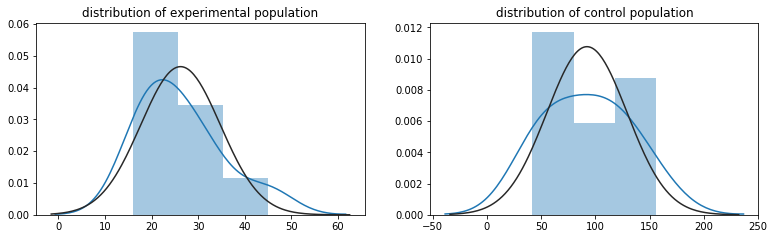

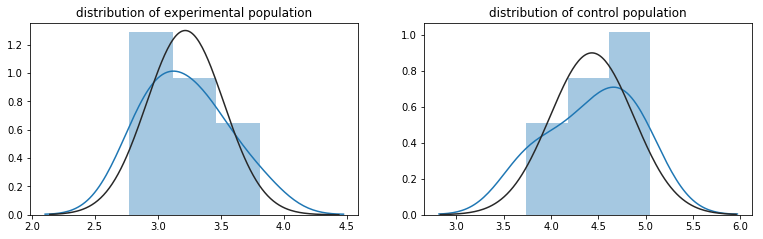

In [21]:
visualize(age_sorted, employee_total_orders)
visualize(np.log(age_sorted), np.log(employee_total_orders))

In [22]:
print(normality_check(age_sorted))
print(normality_check(np.log(age_sorted)))

Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.6030013612753802)
Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.6030013612753802)


Even after log transforming our populations, they are still skewed so we must use a non-parametric test.

#### Formulate Hypothesis

As we have non-parametric, independent, ordinal data, the Mann-Whitney U Test will be used to test whether there is a statistically significant difference between our samples.

- $H_0$: There is **no** statistically significant difference between the number of total orders of each age group.

- $H_\alpha$: There **is** a statistically significant difference between the number of total orders of each age group.

#### Format data for testing

In order to run an ANOVA test on our data, it needs to be formatted into distinct groups. The groups chosen are under 20s, ages 20-29, and ages 30 and over.

In [23]:
orders_employees_df['Age'] = ages
orders_employees_df#

orders_age_df = orders_employees_df.iloc[:,2:]

under_twenties = orders_age_df.loc[orders_age_df['Age'] <20]
under_twenties_orders = under_twenties['Total_Orders'].values

twenties = orders_age_df.loc[(orders_age_df['Age'] >= 20) & (orders_age_df['Age'] < 30)]
twenties_orders = twenties['Total_Orders'].values

thirties_plus = orders_age_df.loc[(orders_age_df['Age'] >= 30)]
thirties_plus_orders = thirties_plus['Total_Orders'].values

print('population 1: (order figures of employees under age 20): ' + str(under_twenties_orders))
print('population 2: (order figures of employees between ages 20-29): ' + str(twenties_orders))
print('population 3: (order figures of employees of age 30 and over): ' + str(thirties_plus_orders))

population 1: (order figures of employees under age 20): [127  67  43]
population 2: (order figures of employees between ages 20-29): [ 42  72 104]
population 3: (order figures of employees of age 30 and over): [123  96 156]


#### Run Test

#### Under 20s vs. 20-29s

In [24]:
stats.mannwhitneyu(under_twenties_orders, twenties_orders)

MannwhitneyuResult(statistic=4.0, pvalue=0.5)

Because our p-value is greater than our chosen alpha 0.05, we fail to reject the null hypothesis. Meaning there is no statistically significant difference in total orders processed by those under age 20.

#### Under 20s vs. 30s+

In [25]:
stats.mannwhitneyu(under_twenties_orders, thirties_plus_orders)

MannwhitneyuResult(statistic=2.0, pvalue=0.19136654444261297)

Because our p-value is greater than our chosen alpha 0.05, we fail to reject the null hypothesis. Meaning there is no statistically significant difference in total orders processed by those under age 20.

#### 20-29s vs. 30s+

In [26]:
stats.mannwhitneyu(twenties_orders, thirties_plus_orders)

MannwhitneyuResult(statistic=1.0, pvalue=0.09521513191276199)

Because our p-value is greater than our chosen alpha 0.05, we fail to reject the null hypothesis. Meaning there is no statistically significant difference in total orders processed by employees in age group 20-29 and those in 30s+.

In [27]:
def run_ANOVA_test(pop1, pop2, pop3, alpha=0.05):
    """ANOVA test for noobs: all mathematical steps laid out 
        and saves you the step needed in built in  Python method 
        of comparing F output from built in method to critical F """
    
    #Calculate mean of all figures in all populations
    def get_grand_mean(population1, population2, population3):
        numerator = np.sum(population1) + np.sum(population2) + np.sum(population3)
        denominator = len(population1) + len(population2) + len(population3)
            
        grand_mean = numerator/denominator
        return grand_mean

    grand_mean = get_grand_mean(pop1, pop2, pop3)

    mean_1 = np.mean(under_twenties_orders)
    mean_2 = np.mean(twenties_orders)
    mean_3 = np.mean(thirties_plus_orders)
    
    #Calculate sum of squares for all figures in all populations
    def get_sum_squares_total(pop1, pop2, pop3):
        sst = []
    
        for i in pop1:
            sst_component_1 = (i - grand_mean)**2
            sst.append(sst_component_1)
        
        for j in pop2:
            sst_component_2 = (j - grand_mean)**2
            sst.append(sst_component_2)
        
        for k in pop3:
            sst_component_3 = (k - grand_mean)**2
            sst.append(sst_component_3)
    
        return sum(sst)

    sum_of_squares_total = get_sum_squares_total(pop1, pop2, pop3)
    
    #Calculate sum of squares within each population
    def get_sum_squares_within(pop1, pop2, pop3):
        ssw = []
    
        for i in pop1:
            ssw_component_1 = (i - mean_1)**2
            ssw.append(ssw_component_1)
        
        for j in pop2:
            ssw_component_2 = (j - mean_2)**2
            ssw.append(ssw_component_2)
        
        for k in pop3:
            ssw_component_3 = (k - mean_3)**2
            ssw.append(ssw_component_3)
    
        return sum(ssw)

    def get_ssw_degrees_of_freedom(m,n):    
        return m*(n-1)

    sum_of_squares_within = get_sum_squares_within(pop1, pop2, pop3)
    ssw_degrees_freedom = get_ssw_degrees_of_freedom(3, len(under_twenties_orders))
    
    #Calculate sum of squares between 
    def get_sum_squares_between(pop1, pop2, pop3):
        ssb = []
    
        for i in pop1:
            ssb_component_1 = (mean_1 - grand_mean)**2
            ssb.append(ssb_component_1)
        
        for j in pop2:
            ssb_component_2 = (mean_2 - grand_mean)**2
            ssb.append(ssb_component_2)
        
        for k in pop3:
            ssb_component_3 = (mean_3 - grand_mean)**2
            ssb.append(ssb_component_3)
    
        return sum(ssb)

    def get_ssb_degrees_of_freedom(m):    
        return m-1

    sum_of_squares_between = get_sum_squares_between(pop1, pop2, pop3)
    ssb_degrees_freedom = get_ssb_degrees_of_freedom(3)
    
    #Calculate F statistic
    def get_f_statistic(ss_between, df_between, ss_within, df_within):
        numerator = ss_between/df_between
        denominator = ss_within/df_within
        return numerator/denominator
    
    f_statistic = get_f_statistic(sum_of_squares_between, ssb_degrees_freedom, sum_of_squares_within, ssw_degrees_freedom)
    
    #Calculate critical F
    def get_critical_f(numerator, denominator):
        critical_f_data = [[19.00, 19.16,19.25,19.30,19.33,19.35,19.37,19.38], [9.55,9.28,9.12,9.01,8.94,8.89,8.85,8.81], [6.94,6.59,6.39,6.26,6.16,6.09,6.04,6.00],[5.79,5.41,5.19,5.05,4.95,4.88,4.82,4.77],[5.14,4.76,4.53,4.39,4.28,4.21,4.15,4.10],[4.74,4.35,4.12,3.97,3.87,3.79,3.73,3.68],[4.46,4.07,3.84,3.69,3.58,3.50,3.44,3.39],[4.26,3.86,3.63,3.48,3.37,3.29,3.23,3.18]] 
        critical_f_df = pd.DataFrame(critical_f_data,columns=[2,3,4,5,6,7,8,9])

        critical_f_df['index_new'] = [2,3,4,5,6,7,8,9]
        critical_f_df = critical_f_df.set_index('index_new')
        critical_f_val = critical_f_df.loc[denominator,numerator]
        
        return critical_f_val
    
    critical_f = get_critical_f(ssb_degrees_freedom, ssw_degrees_freedom)
    
    #---Return values---
    
    #F and critical F
    print(f'f-statistic: {f_statistic}')
    print(f'critical f value: {critical_f}')
    
    #Determine test outcome based on how F value compares to critical Fb
    if f_statistic > critical_f:
        print('test outcome: reject null hypothesis')
    else:
        print('test outcome: fail to reject null hypothesis')

run_ANOVA_test(under_twenties_orders, twenties_orders, thirties_plus_orders)

f-statistic: 1.9651173164421445
critical f value: 5.14
test outcome: fail to reject null hypothesis


In [28]:
get_cohen_d(under_twenties_orders, twenties_orders, 'under twenties age group','twenties age group')
get_cohen_d(under_twenties_orders, thirties_plus_orders, 'under twenties age group','thirties plus age group')
get_cohen_d(twenties_orders, thirties_plus_orders, 'twenties age group','thirties plus age group')

Populations compared: under twenties age group, twenties age group
Cohen's d: 0.20608393492772323
effect size: small
--------------------
Populations compared: under twenties age group, thirties plus age group
Cohen's d: 1.512470683209287
effect size: large
--------------------
Populations compared: twenties age group, thirties plus age group
Cohen's d: 2.099313230059898
effect size: large
--------------------


#### Technical Conclusion

It can be stated with 95% confidence that there is no statistically significant difference betweeen the amount of orders made by employees of different ages.

#### Business Conclusion

There is likely some redundancy in the company's sales force. A topic for further exploration would be to investigate whether experienced employees are being overpaid to do work that an intern would be just as competent at.

<a id="3"></a>
# 3. Is there a statistically significant difference between the average order processing time in North America vs. Western Europe? 

The two pieces of information we are looking to analyze in this question are found in the Customer and Order tables of the database respectively, under the column names "OrderDate" and "shippedDate".

## 3.1 Source Data from Database

In [29]:
orders_cities = sql_select_to_df("""SELECT *
                                FROM [Customer] AS C
                                JOIN [Order] AS O
                                ON O.CustomerID = C.Id
                        """)

## 3.2 Extract Relevant Data

To find the processing time data to test for each region, we will need to find the difference between our 'OrderDate' and 'ShippedDate' columns.

####  Western Europe

In [30]:
#Extract relevant region
western_europe = orders_cities.loc[(orders_cities['ShipRegion'] == 'Western Europe') & (orders_cities['Region'] == 'Western Europe')]
western_europe_dates = western_europe.iloc[:,13:17]

#Convert orderDate, ShippedDate to datetime so they can be operated on
western_europe_dates.OrderDate = pd.to_datetime(western_europe_dates.OrderDate)
western_europe_dates.ShippedDate = pd.to_datetime(western_europe_dates.ShippedDate)

#Calculate processing time and return results
western_europe_dates['ProcessingTime'] = western_europe_dates.ShippedDate - western_europe_dates.OrderDate
processing_time_western_europe = western_europe_dates.ProcessingTime.dt.days
processing_time_western_europe = processing_time_western_europe.dropna()
#processing_time_western_europe.plot.hist()
#processing_time_western_europe
processing_time_western_europe = processing_time_western_europe.values
processing_time_western_europe

array([12.,  5.,  7.,  2., 12.,  3.,  6., 10.,  8., 18.,  8.,  7., 10.,
        4.,  3.,  8.,  6.,  9.,  8.,  6.,  8., 29., 10., 10.,  7.,  5.,
        5.,  7.,  5., 10.,  5.,  6.,  7.,  8., 22.,  9., 12.,  9.,  7.,
       10., 11.,  3.,  8.,  3., 24., 21.,  3.,  3.,  8.,  8., 10.,  8.,
        6., 23.,  6.,  2.,  7., 10., 21., 35.,  4.,  6.,  8.,  7.,  5.,
        9., 20., 21.,  4.,  3.,  6.,  6.,  1.,  2.,  5.,  3., 21.,  8.,
        4.,  6., 12.,  8.,  3.,  8.,  7., 17., 27., 12.,  3.,  6., 24.,
       30.,  3.,  6., 21.,  2.,  2.,  4.,  2., 23.,  5., 25.,  6.,  4.,
        7.,  3.,  6.,  3.,  8.,  3.,  6., 17., 10.,  5., 17.,  4.,  7.,
        8., 35.,  4.,  7.,  9., 12.,  3.,  5.,  8.,  6.,  1.,  5.,  3.,
        6.,  7.,  8.,  1., 10., 17.,  3., 23., 10.,  7.,  8.,  2.,  7.,
        4.,  7.,  4.,  8., 19., 10.,  3.,  8.,  4.,  8.,  6.,  5.,  2.,
        2.,  9.,  8.,  1.,  7.,  6.,  5.,  9.,  2.,  7.,  9.,  2.,  6.,
        9.,  5.,  5.,  5.,  4., 10., 23.,  9.,  5.,  3., 29.,  7

Great, we now have the processing time data in Western Europe (in days) ready for testing.

#### North America

In [31]:
north_america = orders_cities.loc[(orders_cities['ShipRegion'] == 'North America') & (orders_cities['Region'] == 'North America')]
north_america_dates = north_america.iloc[:,13:17]

north_america_dates
north_america_dates.OrderDate = pd.to_datetime(north_america_dates.OrderDate)
north_america_dates.ShippedDate = pd.to_datetime(north_america_dates.ShippedDate)

north_america_dates['ProcessingTime'] = north_america_dates.ShippedDate - north_america_dates.OrderDate
processing_time_north_america = north_america_dates.ProcessingTime.dt.days
processing_time_north_america = processing_time_north_america.dropna()
processing_time_north_america = processing_time_north_america.values

/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


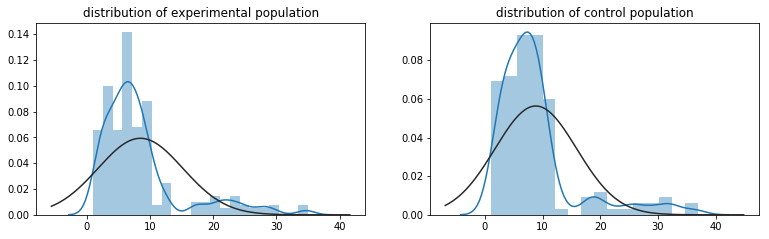

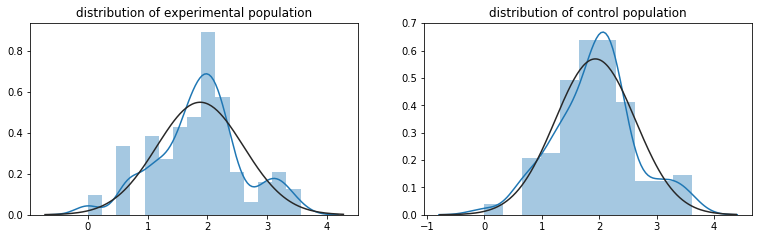

In [32]:
visualize(processing_time_western_europe, processing_time_north_america)
visualize(np.log(processing_time_western_europe), np.log(processing_time_north_america))

In [33]:
print(normality_check(processing_time_western_europe))
print(normality_check(processing_time_north_america))

Ks_2sampResult(statistic=0.21132075471698114, pvalue=1.1098511322741709e-05)
Ks_2sampResult(statistic=0.2635135135135135, pvalue=4.999411933392291e-05)


After log transformming our data it is now normally distributed, wo we will use a parametric test - a two-tail t-test. 

Great, we now have the processing time data in North America (in days) ready for testing.

### 3.3 Test Hypothesis

#### Run Test

Similarly to question 1, here we are testing for **any** statistically significant difference between **two** populations. Therefore we will again make use of the two-tail hypothesis test.

In [34]:
t_test = run_twoSample_tTest(processing_time_western_europe, processing_time_north_america,0.05)
t_test

'fail to reject null hypothesis'

In [35]:
def get_t_test_effect_sizes_twoSample_mod1(experimental,control, pop_name1, pop_name2):
        get_cohen_d(experimental, control, pop_name1, pop_name2)
        
get_t_test_effect_sizes_twoSample_mod1(processing_time_north_america, processing_time_western_europe, 'North America order processing time','Western Europe order processing time')

Populations compared: North America order processing time, Western Europe order processing time
Cohen's d: 0.053277182140876116
effect size: small
--------------------


#### Conclusion

It can be stated with 95% confidence that there is no statistically significant difference between the order processing time in North America and Western Europe

<a id="4"></a>
# 4.0 Which Product Categories Generate Significantly More Revenue Than Average? Which Ones Significantly Less?

The two pieces of information we are looking to analyze in this first part of the question are found in the Product and OrderDetail tables of the database respectively, under the column names "UnitPrice", "Quantity" and "CategoryID".

## 4.1 Source Data From Database

In [36]:
 product_orderDetails_df = sql_select_to_df("""SELECT *
                                FROM [Product] AS P
                                JOIN [OrderDetail] AS O
                                ON P.ID = O.ProductID
                        """)

product_orderDetails_df

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0,10248/11,10248,11,14.00,12,0.00
1,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1,10248/42,10248,42,9.80,10,0.00
2,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0,10248/72,10248,72,34.80,5,0.00
3,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0,10249/14,10249,14,18.60,9,0.00
4,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0,10249/51,10249,51,42.40,40,0.00
5,41,Jack's New England Clam Chowder,19,8,12 - 12 oz cans,9.65,85,0,10,0,10250/41,10250,41,7.70,10,0.00
6,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0,10250/51,10250,51,42.40,35,0.15
7,65,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,21.05,76,0,0,0,10250/65,10250,65,16.80,15,0.15
8,22,Gustaf's Knäckebröd,9,5,24 - 500 g pkgs.,21.00,104,0,25,0,10251/22,10251,22,16.80,6,0.05
9,57,Ravioli Angelo,26,5,24 - 250 g pkgs.,19.50,36,0,20,0,10251/57,10251,57,15.60,15,0.05


## 4.2 Obtain Data for Testing

#### 4.2.1 Extract Relevant Data

The first step will be to extract the two lists from our data that will later be used to formulate our experiment groups. They are: 
- categoryID 
- revenues

In [37]:
#Extract category IDs
category_IDs = product_orderDetails_df['CategoryId'].values
category_IDs = list(category_IDs)

#Extract revenues
prices = product_orderDetails_df.iloc[:,13].values
quantities = product_orderDetails_df['Quantity'].values

revenues = prices * quantities
revenues = list(revenues)
print({'categoryIDs':category_IDs ,'revenues':revenues})

{'categoryIDs': [4, 5, 4, 7, 7, 8, 7, 2, 5, 5, 2, 3, 4, 4, 4, 1, 3, 1, 6, 7, 1, 3, 8, 4, 6, 2, 3, 1, 2, 1, 2, 4, 3, 8, 8, 5, 3, 1, 3, 1, 2, 7, 5, 3, 1, 8, 7, 1, 8, 6, 1, 4, 8, 4, 1, 6, 4, 4, 4, 8, 1, 4, 3, 4, 4, 8, 4, 4, 8, 1, 4, 4, 1, 4, 8, 8, 7, 3, 2, 4, 2, 8, 6, 1, 6, 1, 3, 1, 1, 8, 5, 2, 3, 4, 4, 3, 2, 4, 1, 1, 8, 6, 1, 3, 3, 1, 8, 6, 3, 2, 5, 2, 6, 3, 2, 8, 2, 7, 3, 8, 1, 2, 1, 1, 6, 1, 4, 1, 5, 4, 3, 4, 1, 4, 1, 8, 4, 3, 3, 1, 2, 3, 8, 5, 6, 7, 1, 8, 2, 3, 3, 4, 4, 8, 6, 1, 8, 6, 6, 3, 3, 4, 1, 2, 2, 5, 1, 4, 3, 3, 5, 4, 7, 1, 6, 1, 8, 4, 8, 3, 1, 1, 8, 3, 1, 8, 1, 6, 7, 1, 4, 1, 5, 2, 3, 1, 3, 1, 8, 4, 2, 2, 8, 7, 4, 4, 2, 5, 1, 1, 4, 8, 8, 4, 2, 3, 3, 8, 1, 5, 3, 4, 6, 8, 5, 3, 7, 3, 4, 5, 3, 1, 4, 4, 7, 2, 5, 3, 8, 8, 4, 6, 8, 2, 6, 3, 8, 8, 1, 4, 4, 1, 4, 8, 6, 5, 3, 1, 2, 2, 2, 3, 5, 6, 5, 3, 1, 8, 1, 1, 5, 6, 3, 4, 1, 8, 2, 2, 1, 6, 4, 1, 1, 6, 1, 5, 4, 6, 4, 8, 3, 4, 1, 1, 8, 3, 4, 4, 7, 6, 1, 3, 6, 1, 4, 3, 7, 6, 4, 1, 1, 4, 4, 4, 2, 2, 1, 6, 2, 2, 3, 7, 5, 5, 6, 5, 1, 5,

Success. Now we need to boil this raw data into something we can use by formulating experimental groups for our tests.

#### 4.2.2 Get Revenue figures by Individual Categories

In order to answer our test question, we need to find a way to create individual experimental groups for each category. The first step towards doing this is to determine what unique categories exist in our dataset?

In [38]:
unique_categories = sorted(product_orderDetails_df['CategoryId'].unique())
print(unique_categories)

[1, 2, 3, 4, 5, 6, 7, 8]


OK. Next to generate the revenue figures for each.

In [39]:
def get_revenues_by_category(categoryNum, revenues_list, IDs_list):
    """Loops through revenues list and pushes relevant figure to list to be returned."""
    master_list = []
    iterator_count = 0
    
    for i in IDs_list:
        if i == categoryNum:
            master_list.append(revenues_list[iterator_count])
    
        iterator_count+=1
    
    return master_list

def get_revenues_by_category_all(categories_unique, revenues_list,IDs_list):
    master_list = []
    for c in categories_unique:
        category_data = [{'id':c, 'revenues data':get_revenues_by_category(c,revenues_list,IDs_list)}]
        master_list.append(category_data)
    
    return master_list


#id1_revenues = get_revenues_by_category(1,revenues,category_IDs)
#id2_revenues = get_revenues_by_category(2,revenues,category_IDs)
#id3_revenues = get_revenues_by_category(3,revenues,category_IDs)
#id4_revenues = get_revenues_by_category(4,revenues,category_IDs)
#id5_revenues = get_revenues_by_category(5,revenues,category_IDs)
#id6_revenues = get_revenues_by_category(6,revenues,category_IDs)
#id7_revenues = get_revenues_by_category(7,revenues,category_IDs)
#id8_revenues = get_revenues_by_category(8,revenues,category_IDs)

revenues_by_category_all = get_revenues_by_category_all(unique_categories, revenues, category_IDs)
revenues_by_category_all

[[{'id': 1,
   'revenues data': [604.8000000000001,
    54.0,
    304.0,
    86.4,
    760.0,
    252.0,
    288.0,
    100.8,
    532.0,
    240.0,
    216.0,
    919.9999999999999,
    475.2,
    43.2,
    43.2,
    186.0,
    21.6,
    57.6,
    56.0,
    648.0,
    1440.0,
    224.0,
    36.0,
    37.2,
    259.2,
    552.0,
    37.2,
    864.0,
    608.0,
    240.0,
    441.59999999999997,
    432.0,
    60.0,
    736.0,
    883.1999999999999,
    62.0,
    156.79999999999998,
    360.0,
    288.0,
    86.4,
    432.0,
    144.0,
    57.6,
    1008.0,
    310.0,
    380.0,
    4216.0,
    106.39999999999999,
    1472.0,
    364.79999999999995,
    216.0,
    720.0,
    37.2,
    216.0,
    4216.0,
    36.0,
    10540.0,
    172.8,
    90.0,
    36.0,
    112.0,
    2108.0,
    777.6,
    74.4,
    172.8,
    403.2,
    216.0,
    8432.0,
    288.0,
    360.0,
    54.0,
    112.0,
    54.0,
    360.0,
    576.0,
    380.0,
    432.0,
    504.0,
    504.0,
    144.0,
    345.6,
    

#### 4.2.3 Create Control and Experimental Groups for Testing

Next to generate our control groups for each experiment. This will be done with the below function.

In [40]:
def get_experimental_population(experimental_id, revenues_id_list_of_dicts, logged=False):
        experimental_id_index = experimental_id - 1
        experimental = revenues_id_list_of_dicts[experimental_id_index][0]['revenues data']
        experimental = np.array(experimental)
        experimental_logged = np.log(experimental)
        
        if logged == False:
            return experimental
        else:
            return experimental_logged
        
def get_control_population(experimental_id, revenues_id_list_of_dicts, logged=False):
    experimental_id_index = experimental_id - 1
    experimentals = []
    experimentals_logged = []
    
    i=1
    while i < len(unique_categories)+1: 
        experimental = get_experimental_population(i, revenues_id_list_of_dicts)
        experimental_logged = np.log(experimental)
        experimentals.append(experimental)
        experimentals_logged.append(experimental_logged)
        i+=1
    
    del experimentals[experimental_id_index]
    
    experimentals = np.array(experimentals) 
    experimentals_logged = np.array(experimentals_logged)
    
    
    if logged == False:
        return experimentals
    else:
        return experimental_logged

get_control_population(8,revenues_by_category_all)
#get_experimental_population(8,revenues_by_category_all,True)

array([array([6.04800e+02, 5.40000e+01, 3.04000e+02, 8.64000e+01, 7.60000e+02,
       2.52000e+02, 2.88000e+02, 1.00800e+02, 5.32000e+02, 2.40000e+02,
       2.16000e+02, 9.20000e+02, 4.75200e+02, 4.32000e+01, 4.32000e+01,
       1.86000e+02, 2.16000e+01, 5.76000e+01, 5.60000e+01, 6.48000e+02,
       1.44000e+03, 2.24000e+02, 3.60000e+01, 3.72000e+01, 2.59200e+02,
       5.52000e+02, 3.72000e+01, 8.64000e+02, 6.08000e+02, 2.40000e+02,
       4.41600e+02, 4.32000e+02, 6.00000e+01, 7.36000e+02, 8.83200e+02,
       6.20000e+01, 1.56800e+02, 3.60000e+02, 2.88000e+02, 8.64000e+01,
       4.32000e+02, 1.44000e+02, 5.76000e+01, 1.00800e+03, 3.10000e+02,
       3.80000e+02, 4.21600e+03, 1.06400e+02, 1.47200e+03, 3.64800e+02,
       2.16000e+02, 7.20000e+02, 3.72000e+01, 2.16000e+02, 4.21600e+03,
       3.60000e+01, 1.05400e+04, 1.72800e+02, 9.00000e+01, 3.60000e+01,
       1.12000e+02, 2.10800e+03, 7.77600e+02, 7.44000e+01, 1.72800e+02,
       4.03200e+02, 2.16000e+02, 8.43200e+03, 2.88000e+02

With this function in place we can now create experimental and control groups for each product category

In [41]:
#category1_data = get_experimental_and_control_population(1,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category1_data_experimental = category1_data['experimental']
#category1_data_control = category1_data['control']

#category2_data = get_experimental_and_control_population(2,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category2_data_experimental = category2_data['experimental']
#category2_data_control = category2_data['control']

#category3_data = get_experimental_and_control_population(3,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category3_data_experimental = category3_data['experimental']
#category3_data_control = category3_data['control']

#category4_data = get_experimental_and_control_population(4,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category4_data_experimental = category4_data['experimental']
#category4_data_control = category4_data['control']

#category5_data = get_experimental_and_control_population(5,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category5_data_experimental = category5_data['experimental']
#category5_data_control = category5_data['control']

#category6_data = get_experimental_and_control_population(6,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category6_data_eaxperimental = category6_data['experimental']
#category6_data_control = category6_data['control']

#category7_data = get_experimental_and_control_population(7,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category7_data_experimental = category7_data['experimental']
#category7_data_control = category7_data['control']

#category8_data = get_experimental_and_control_population(8,[id1_revenues, id2_revenues, id3_revenues, id4_revenues, id5_revenues, id6_revenues, id7_revenues, id8_revenues])
#category8_data_experimental = category8_data['experimental']
#category8_data_control = category8_data['control']

Groups generated. Ready for testing!

## 4.3 Test Hypothesis

#### Formulate Hypothesis

Because we are interested whether our sample mean is **significantly less than or greater than**  our population mean, a **one-sample** t test will be chosen. The null and alternate hypotheses for this test are the following:


- $H_0$: There is no statistically significant difference between the mean revenue generated by product category x and the mean of all other product categories.

- $H_\alpha$: product category x generated significantly more/less revenue than the mean of all other product categories

#### Run Tests

In [42]:
def one_sample_ttest(sample_data, population_data, alpha):
    
    #Population mean
    mu_calc_figures = []
        
    for p in population_data:
        for elem in p:
            mu_calc_figures.append(elem)
        
    mu = sum(mu_calc_figures)/len(mu_calc_figures)
    
    x_bar = sum(sample_data)/len(sample_data)
    
    #Sigma
    sample_data_arr = np.asarray(sample_data)
    sigma = np.std(sample_data_arr)
    
    #Degrees of Freedom
    df = len(sample_data) -1
    
    #Sample size
    n = len(sample_data)
    
    #Critical t value
    t_crit_positive = stats.t.ppf(1 - alpha, df=df)
    t_crit_negative = t_crit_positive * -1
    
    #T statistic
    t_stat_numerator = x_bar - mu
    t_stat_denominator = sigma/math.sqrt(n)
    t_stat = t_stat_numerator/t_stat_denominator
    
    if int(t_stat*100) in range(int(t_crit_negative*100), int(t_crit_positive*100)):
        return 'fail to reject the null hypothesis'
    elif int(t_stat*100) < int(t_crit_negative*100):
        return 'reject the null hypothesis. Sample mean is significantly less than population mean'
    elif int(t_stat*100) > int(t_crit_positive*100):
        return 'reject the null hypothesis. Sample mean is significantly greater than population mean'
    print(t_stat)

In [43]:
#category1_test_outcome = one_sample_ttest(category1_data_experimental, category1_data_control, 0.05)
#category2_test_outcome = one_sample_ttest(category2_data_experimental, category2_data_control, 0.05)
#category3_test_outcome = one_sample_ttest(category3_data_experimental, category3_data_control, 0.05)
#category4_test_outcome = one_sample_ttest(category4_data_experimental, category4_data_control, 0.05)
#category5_test_outcome = one_sample_ttest(category5_data_experimental, category5_data_control, 0.05)
#category6_test_outcome = one_sample_ttest(category6_data_experimental, category6_data_control, 0.05)
#category7_test_outcome = one_sample_ttest(category7_data_experimental, category7_data_control, 0.05)
#category8_test_outcome = one_sample_ttest(category8_data_experimental, category8_data_control, 0.05)

#### Technical Conclusion

In [44]:
#print(f'Test outcome of category 1: {category1_test_outcome}')
#print(f'Test outcome of category 2: {category2_test_outcome}')
#print(f'Test outcome of category 3: {category3_test_outcome}')
#print(f'Test outcome of category 4: {category4_test_outcome}')
#print(f'Test outcome of category 5: {category5_test_outcome}')
#print(f'Test outcome of category 6: {category4_test_outcome}')
#print(f'Test outcome of category 7: {category7_test_outcome}')
#print(f'Test outcome of category 8: {category8_test_outcome}')

Ks_2sampResult(statistic=0.07425742574257421, pvalue=0.20681926716151375)
Ks_2sampResult(statistic=0.03997715591090811, pvalue=0.11896633062370217)


/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site

Ks_2sampResult(statistic=0.125, pvalue=0.06283556728785016)
Ks_2sampResult(statistic=0.05882352941176472, pvalue=0.004442895902482996)
Ks_2sampResult(statistic=0.06287425149700598, pvalue=0.5110275422215318)
Ks_2sampResult(statistic=0.05368360936607652, pvalue=0.012333950193420377)
Ks_2sampResult(statistic=0.08469945355191255, pvalue=0.13767800121052395)
Ks_2sampResult(statistic=0.07081667618503712, pvalue=0.00028537481886803834)
Ks_2sampResult(statistic=0.10204081632653061, pvalue=0.24562486342179812)
Ks_2sampResult(statistic=0.06910336950314105, pvalue=0.0004357554398976417)


/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Ks_2sampResult(statistic=0.07514450867052024, pvalue=0.6965562684889026)
Ks_2sampResult(statistic=0.03655054254711598, pvalue=0.18890042894966672)
Ks_2sampResult(statistic=0.08823529411764705, pvalue=0.6450784044831687)
Ks_2sampResult(statistic=0.04111936036550545, pvalue=0.1010252006503765)
Ks_2sampResult(statistic=0.0787878787878788, pvalue=0.2469810357485527)
Ks_2sampResult(statistic=0.05482581382067392, pvalue=0.009909741883136753)


/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


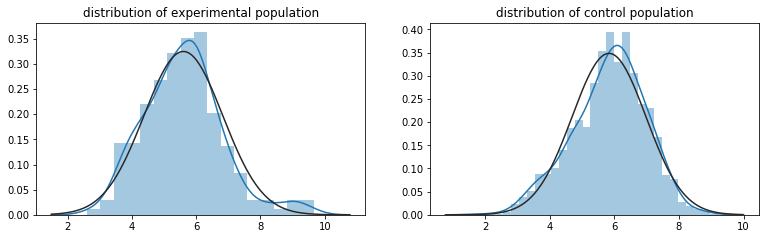

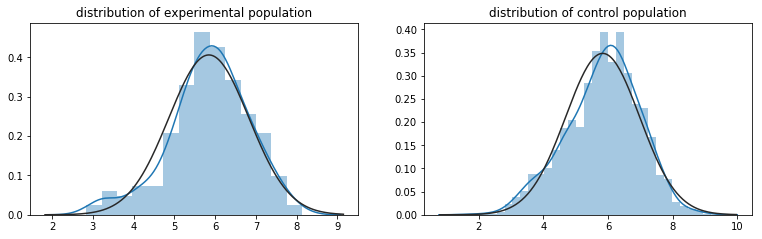

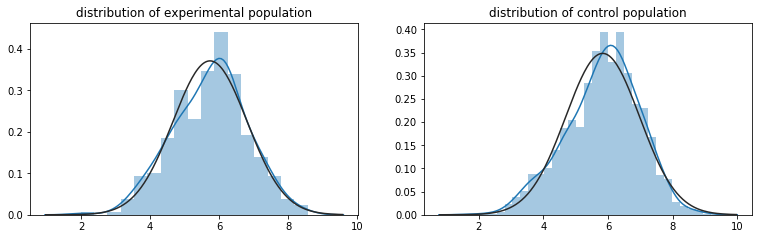

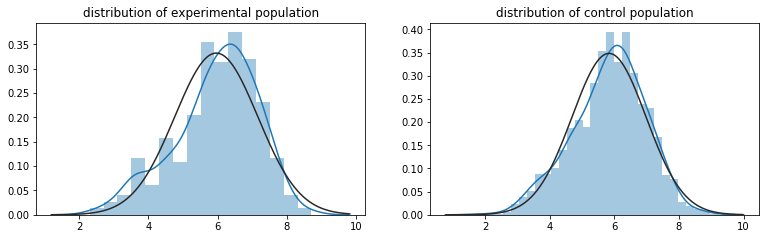

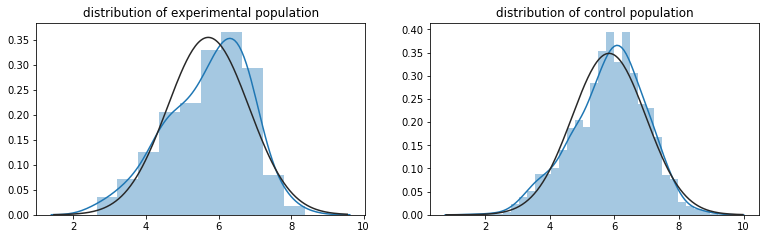

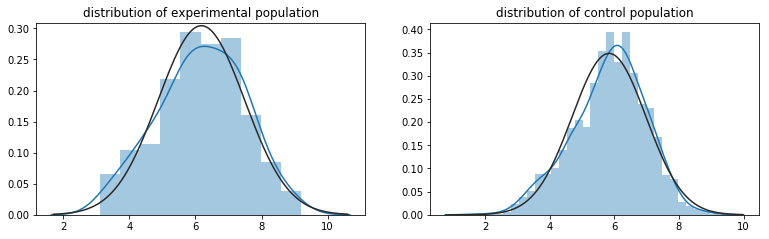

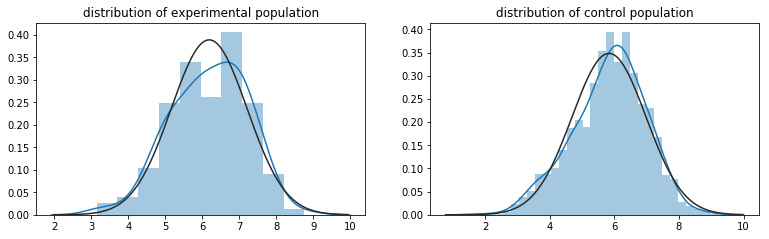

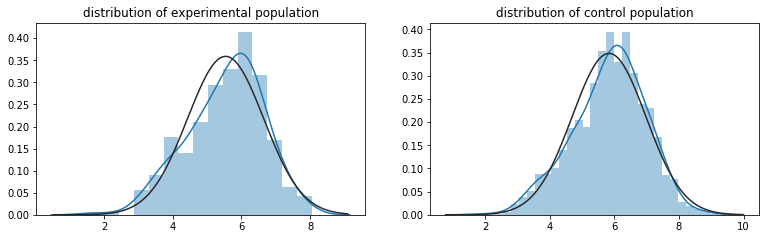

In [45]:
def visualize_all(category_list, logged = False):
    i=1
    j=0
    
    control_initial = get_control_population(i,revenues_by_category_all)
    
    control_final = []
    control_final_logged = []
    
    while j < len(control_initial):
        for c in control_initial[j]:
            control_final.append(c)
            
        j+=1
    
    control_final = np.array(control_final)
    control_final_logged = np.array(control_final_logged)
    
    while i < len(category_list)+1:
        experimental = get_experimental_population(i,revenues_by_category_all)
        experimental = np.array(experimental)
        
        if logged == False:
            visualize(experimental, control_final)
            print(normality_check(experimental))
            print(normality_check(control_final))
        else:
            visualize(np.log(experimental), np.log(control_final))
            print(normality_check(np.log(experimental)))
            print(normality_check(np.log(control_final)))
        i+=1

visualize_all(unique_categories,True)

The data in our experimental and control populations are normally distributed, so we will use a parametric test, a t-test to test for difference in our means.

In [49]:
def get_t_test_outcomes_oneSample(category_list):
    i=1
    
    while i < len(category_list)+1:
        print(f'Test outcome of category {i}: ' + one_sample_ttest(get_experimental_population(i,revenues_by_category_all), get_control_population(i,revenues_by_category_all),0.05))
        i+=1
        
get_t_test_outcomes_oneSample(unique_categories)

Test outcome of category 1: fail to reject the null hypothesis
Test outcome of category 2: reject the null hypothesis. Sample mean is significantly less than population mean
Test outcome of category 3: reject the null hypothesis. Sample mean is significantly less than population mean
Test outcome of category 4: reject the null hypothesis. Sample mean is significantly greater than population mean
Test outcome of category 5: reject the null hypothesis. Sample mean is significantly less than population mean
Test outcome of category 6: reject the null hypothesis. Sample mean is significantly greater than population mean
Test outcome of category 7: reject the null hypothesis. Sample mean is significantly greater than population mean
Test outcome of category 8: reject the null hypothesis. Sample mean is significantly less than population mean


In [47]:
def get_t_test_effect_sizes_oneSample(category_list):
    i=1
    j=0
    
    control_initial = get_control_population(i,revenues_by_category_all)
    control_final = []
    
    while j < len(control_initial):
        for c in control_initial[j]:
            control_final.append(c)
            
        j+=1
    
    control_final = np.array(control_final)
    
    while i < len(category_list)+1:
        experimental = get_experimental_population(i,revenues_by_category_all)
        experimental = np.array(experimental)
                
        get_cohen_d(experimental, control_final, f'category {i} experimental',f'category {i} control')
        
        i+=1

get_t_test_effect_sizes_oneSample(unique_categories)

Populations compared: category 1 experimental, category 1 control
Cohen's d: 0.0959216632222804
effect size: small
--------------------
Populations compared: category 2 experimental, category 2 control
Cohen's d: 0.11246350086346475
effect size: small
--------------------
Populations compared: category 3 experimental, category 3 control
Cohen's d: 0.10656965925981757
effect size: small
--------------------
Populations compared: category 4 experimental, category 4 control
Cohen's d: 0.10063794106674519
effect size: small
--------------------
Populations compared: category 5 experimental, category 5 control
Cohen's d: 0.12850395324977715
effect size: small
--------------------
Populations compared: category 6 experimental, category 6 control
Cohen's d: 0.49483383091917993
effect size: medium
--------------------
Populations compared: category 7 experimental, category 7 control
Cohen's d: 0.21329304215611755
effect size: small
--------------------
Populations compared: category 8 experime

#### Business Conclusion

We can see that the revenues generated by each category are quite polarizing. 7 of the 8 categories have a significant difference in mean than the rest of the population. 

The "heavy lifter" product categories generating above average revenue are:
- 4
- 6
- 7

The "par for the course" product category that generates about average revenue is:
- 1

The "lagging behind" categories that generate below average revenue are:
- 2
- 3
- 5
- 8

The company should investigate ways to increase their stock of products of category 4,6,7; and either decrease their stock of products of category 2,3,5,8, mark up their price, or find a way to increase quantity sold through marketing.